# DPVI implementation

This notebook is an implementation of the DPVI algorithm for differentially private variational inference. The algorithm is described in the paper "Differentially Private Variational Inference for Non-conjugate Models"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.distributions import Normal, Gamma
from torch.nn import Module, Parameter
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [2]:
# Load the data
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

X, y = load_breast_cancer(return_X_y=True)

scaler = StandardScaler()

X = scaler.fit_transform(X)

X = X[:, :4] # Only use the first two features
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)  # Add a bias term

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# To dataloader
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model

The model is a binary logistic regression model with a Gaussian prior on the weights. The likelihood is given by

$$
p(y | x, w) = \sigma(y w^T x)
$$

where $\sigma(x)=1/(1+e^{-x})$ is the sigmoid function. The prior is given by

$$
p(w) = \mathcal{N}(w | 0, \sigma^2 I)
$$

where $\sigma^2$ is the variance of the prior.


## Variational distribution

The variational distribution is given by

$$
q(w) = \mathcal{N}(w | \mu, \Sigma)
$$

where $\mu$ and $\Sigma$ are the variational parameters.

## Objective

The objective is to maximize the ELBO

$$
\mathcal{L} = \mathbb{E}_{q(w)}[\log p(y | x, w)] - \text{KL}(q(w) || p(w))
$$


In [3]:
# Model
class BayesianLogisticRegression(Module):
    def __init__(self, n_features, sigma_prior=1):
        super().__init__()
        self.n_features = n_features
        
        # Priors for the weights
        self.prior_mean = torch.zeros(n_features)
        self.prior_std = torch.ones(n_features) * sigma_prior

        # Variational parameters
        self.mean = Parameter(torch.randn(n_features))
        self.rho = Parameter(torch.randn(n_features)) # log(sigma)

    def kl_divergence(self):
        # Compute the KL divergence
        q = Normal(self.mean, torch.exp(self.rho))
        p = Normal(self.prior_mean, self.prior_std)
        return torch.distributions.kl_divergence(q, p).sum()

    def log_likelihood(self, X, y):
        y_pred = self(X)
        return torch.distributions.Bernoulli(y_pred).log_prob(y).sum()

    def loss(self, X, y):
        return self.kl_divergence() - self.log_likelihood(X, y)

    def loss_single(self, x, y, N):
        return self.kl_divergence() / N - self.log_likelihood(x, y)

    def forward(self, X):
        # Sample the weights (reparametrization trick)
        w = Normal(self.mean, torch.exp(self.rho)).rsample()

        # Compute the probabilities
        logits = torch.matmul(X, w)
        return torch.sigmoid(logits)

In [5]:
# Training
torch.manual_seed(42)

model = BayesianLogisticRegression(n_features=X.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epochs = 500
losses_nodp = []
betas_nodp = []

pbar = tqdm(total=n_epochs)

for epoch in range(n_epochs):
    loss_epoch = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        loss = model.loss(X_batch, y_batch)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
    
    betas_nodp.append(model.mean.detach().numpy().copy())
    losses_nodp.append(loss_epoch / len(X_train))

    pbar.set_postfix({'loss': losses_nodp[-1]})
    pbar.update()

losses_nodp = np.array(losses_nodp)
betas_nodp = np.array(betas_nodp)

  0%|          | 0/500 [00:00<?, ?it/s]

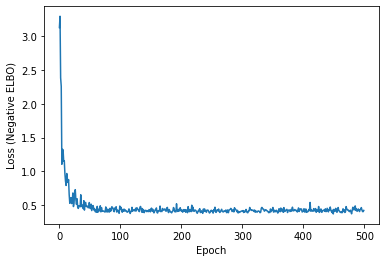

In [6]:
# Plot the loss

plt.plot(losses_nodp)
plt.xlabel('Epoch')
plt.ylabel('Loss (Negative ELBO)')
plt.show()

In [7]:
# Predictions
from sklearn.metrics import accuracy_score

torch.manual_seed(42)

y_pred = model(test_dataset.X).detach().numpy() > 0.5

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9064


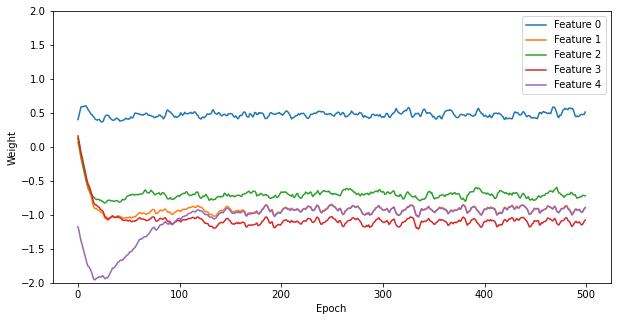

In [8]:
# Plot the weights

plt.figure(figsize=(10, 5))
for i in range(X.shape[1]):
    plt.plot(betas_nodp[:, i], label=f'Feature {i}')
plt.xlabel('Epoch')
plt.ylabel('Weight')
plt.ylim(-2, 2)
plt.legend()
plt.show()

## With Differential Privacy

In [9]:
# Sampler
from torch.utils.data import Sampler

class RandomSampler(Sampler[int]):
    def __init__(self, data_source, sampling_prob):
        self.data_source = data_source
        self.sampling_prob = sampling_prob
        self.indices = [i for i in range(len(self.data_source)) if np.random.rand() < self.sampling_prob]

    def __len__(self):
        return len(self.indices)

    def __iter__(self):
        return iter(self.indices)

# Test the sampler
sampler = RandomSampler(train_dataset, 0.5)
dataloader = DataLoader(train_dataset, sampler=sampler)
len(dataloader)

195

In [10]:
# DPVI
torch.manual_seed(42)

from torch.nn.utils import clip_grad_norm_
from torch.utils.data import WeightedRandomSampler

loss_collection = dict()
beta_collection = dict()

for epsilon in [0.01, 0.1, 1.0, 10.0]:

    lr = 0.01
    n_epochs = 500
    losses = []
    betas = []
    sampling_prob = 0.05
    clipping_threshold = 5.0
    delta = 1e-3

    noise_multiplier = np.sqrt(2 * np.log(1.25 / delta)) / epsilon

    # Initialize the model

    model_dp = BayesianLogisticRegression(n_features=X.shape[1])
    optimizer = torch.optim.Adam(model_dp.parameters(), lr=lr)

    pbar = tqdm(range(n_epochs))

    # DPVI algorithm

    losses = []
    betas = []

    for epoch in pbar:
        beta_epoch = []
        loss_epoch = 0

        # Sample the minibatches (sampling_prob is the probability of including a sample in the minibatch)
        sampler = RandomSampler(train_dataset, sampling_prob)
        dataloader = DataLoader(train_dataset, sampler=sampler)

        # Initialize the accumulated gradients
        for p in model_dp.parameters():
            p.accumulated_grads = []

        for x, y in dataloader:
            optimizer.zero_grad()
            loss = model_dp.loss(x, y)
            loss.backward()
            loss_epoch += loss.item()

            for p in model_dp.parameters():
                per_sample_grad = p.grad.detach().clone()
                clip_grad_norm_(per_sample_grad, clipping_threshold) # in-place operation
                p.accumulated_grads.append(per_sample_grad)

            
        # Aggregate the gradients
        for p in model_dp.parameters():
            p.grad = torch.stack(p.accumulated_grads).sum(dim=0)
            p.grad += torch.randn_like(p.grad) * clipping_threshold * noise_multiplier

        optimizer.step()
        model_dp.zero_grad()

        betas.append(model_dp.mean.detach().numpy().copy())
        losses.append(loss_epoch / len(dataloader))

        pbar.set_description(f'epsilon={epsilon}')
        pbar.set_postfix({'loss': losses[-1]})

    losses = np.array(losses)
    betas = np.array(betas)

    loss_collection[epsilon] = losses
    beta_collection[epsilon] = betas

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

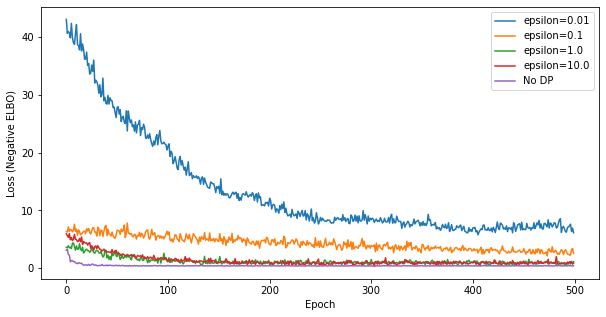

In [11]:
# Plot the loss for different epsilon values
plt.figure(figsize=(10, 5))
for epsilon, losses in loss_collection.items():
    plt.plot(losses, label=f'epsilon={epsilon}')

plt.plot(losses_nodp, label=f'No DP')
plt.xlabel('Epoch')
plt.ylabel('Loss (Negative ELBO)')
plt.legend()
plt.show()

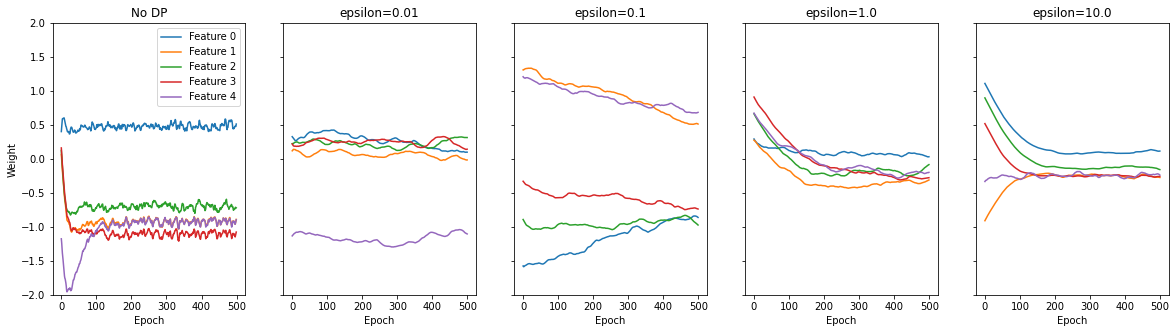

In [12]:
# Plot the weights for different epsilon values

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

# no dp
for j in range(X.shape[1]):
    axes[0].plot(betas_nodp[:, j], label=f'Feature {j}')
axes[0].set_title('No DP')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Weight')
axes[0].set_ylim(-2, 2)
axes[0].legend()

for i, ax in enumerate(axes.flat):
    if i ==0:
        continue
    epsilon = list(loss_collection.keys())[i-1]
    betas = beta_collection[epsilon]
    for j in range(X.shape[1]):
        ax.plot(betas[:, j], label=f'Feature {j}')
    ax.set_title(f'epsilon={epsilon}')
    ax.set_xlabel('Epoch')